In [56]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [57]:
#Données
r =[10, 23, 23, 26, 17, 5, 53, 55, 32, 46, 10, 8, 10, 8, 23, 0, 3, 22, 15, 32, 3]
n = [39, 62, 81, 51, 39, 6, 74, 72, 51, 79, 13, 16, 30, 28, 45, 4, 12, 41, 30, 51, 7]
x1 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
x2 = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

In [58]:
#Fonctions utiles:
def sigm(x): #Fonction sigmoïde
    return 1/(1+np.exp(-x))
def p(alpha0,alpha1,x1,alpha2,x2,alpha12,b):
    return sigm(alpha0+alpha1*x1+alpha2*x2+alpha12*x1*x2+b)

def R(alpha0,alpha1,alpha2,alpha12,b): 
    a=0 #vraisemblance r
    for i in range(K):
        a += r[i]*np.log(p(alpha0,alpha1,x1[i],alpha2,x2[i],alpha12,b[i]))+(n[i]-r[i])*np.log(1-p(alpha0,alpha1,x1[i],alpha2,x2[i],alpha12,b[i]))
    return a
    
N=10000 #Nombre d'itérations de l'échantilloneur
K=21 #Nombre de "strates"

#Echantilloneur:
def GibbsSampler(N,std_dev,alpha0,alpha1,alpha2,alpha12,sigma,b):
    X=np.zeros((N+1,5)) # alpha0,alpha1,alpha2,alpha12,sigma
    Xb=np.zeros((N+1,K))
    #Initialisation
    X[0]=[alpha0,alpha1,alpha2,alpha12,sigma]
    Xb[0]=b

    for j in range(N):

        #Mise à jour alpha0
        X[j+1]=X[j]
        Xp=X[j+1][0]+std_dev[0]*np.random.normal() #proposition alpha
        top0=-Xp**2/2000000 #loi a priori
        top1=R(Xp,X[j+1][1],X[j+1][2],X[j+1][3],Xb[j+1])
        top=top0+top1
        bottom0=-X[j+1][0]**2/2000000 #loi a priori
        bottom1=R(Xp,X[j+1][1],X[j+1][2],X[j+1][3],Xb[j+1]) #vraisemblance
        bottom=bottom0+bottom1
        prob=np.exp(top-bottom)
        if np.random.uniform()<prob:
            X[j+1][0]=Xp
        
        #Mise à jour alpha1
        X[j+1]=X[j]
        Xp=X[j+1][1]+std_dev[1]*np.random.normal() #proposition alpha
        top0=-Xp**2/2000000 #loi a priori
        top1=R(X[j+1][0],Xp,X[j+1][2],X[j+1][3],Xb[j+1])
        top=top0+top1
        bottom0=-X[j+1][1]**2/2000000 #loi a priori
        bottom1=R(X[j+1][0],Xp,X[j+1][2],X[j+1][3],Xb[j+1]) #vraisemblance
        bottom=bottom0+bottom1
        prob=np.exp(top-bottom)
        if np.random.uniform()<prob:
            X[j+1][1]=Xp

        #Mise à jour alpha2
        X[j+1]=X[j]
        Xp=X[j+1][2]+std_dev[2]*np.random.normal() #proposition alpha
        top0=-Xp**2/2000000 #loi a priori
        top1=R(X[j+1][0],X[j+1][1],Xp,X[j+1][3],Xb[j+1])
        top=top0+top1
        bottom0=-X[j+1][2]**2/2000000 #loi a priori
        bottom1=R(X[j+1][0],X[j+1][1],Xp,X[j+1][3],Xb[j+1]) #vraisemblance
        bottom=bottom0+bottom1
        prob=np.exp(top-bottom)
        if np.random.uniform()<prob:
            X[j+1][2]=Xp

        #Mise à jour alpha12
        X[j+1]=X[j]
        Xp=X[j+1][3]+std_dev[3]*np.random.normal() #proposition alpha
        top0=-Xp**2/2000000 #loi a priori
        top1=R(X[j+1][0],X[j+1][1],X[j+1][2],Xp,Xb[j+1])
        top=top0+top1
        bottom0=-X[j+1][3]**2/2000000 #loi a priori
        bottom1=R(X[j+1][0],X[j+1][1],X[j+1][2],Xp,Xb[j+1]) #vraisemblance
        bottom=bottom0+bottom1
        prob=np.exp(top-bottom)
        if np.random.uniform()<prob:
            X[j+1][3]=Xp
        
        #Mise à jour sigma
        Xp=X[j+1][4]*np.random.lognormal() #proposition sigma: marche aléatoire lognormale
        top=-2.002*np.log(Xp)-0.001/Xp**2-np.sum(np.array(b)**2)/(2*Xp**2)
        bottom=-2.002*np.log(X[j+1][4])-0.001/X[j+1][4]**2-np.sum(np.array(b)**2)/(2*X[j+1][4]**2)
        prob=np.exp(top-bottom)*Xp/X[j+1][4]
        if np.random.uniform()<prob:
            X[j+1][4]=Xp
        
        #p(alpha0,alpha1,x1,alpha2,x2,alpha12,b)
        #Mise à jour b
        Xb[j+1]=Xb[j]
        for i in range(K):
            Xp=Xb[j+1][i]+std_dev[4]*np.random.normal() #propoisition b
            top0=-Xp**2/2000 #loi a priori b
            top1=r[i]*np.log(p(X[j+1][0],X[j+1][1],x1[i],X[j+1][2],x2[i],X[j+1][3],Xp))+(n[i]-r[i])*np.log(1-p(X[j+1][0],X[j+1][1],x1[i],X[j+1][2],x2[i],X[j+1][3],Xp))
            top=top0+top1
            bottom0=-Xb[j+1][i]**2/2000 #loi a priori
            bottom1=r[i]*np.log(p(X[j+1][0],X[j+1][1],x1[i],X[j+1][2],x2[i],X[j+1][3],Xb[j+1][i]))+(n[i]-r[i])*np.log(1-p(X[j+1][0],X[j+1][1],x1[i],X[j+1][2],x2[i],X[j+1][3],Xb[j+1][i]))
            bottom=bottom0+bottom1
            prob=np.exp(top-bottom)
            if np.random.uniform()<prob:
                Xb[j+1][i]=Xp

    return X,Xb

In [59]:
std_dev=[0.1,0.2,0.15,0.3,0.3] #Variance des propositions (ajustées)

#Valeurs initiales (ajustées):
alpha0=-1.7
alpha1=0
alpha2=0
alpha12=0
b=[0]*K
sigma=0.1
N=5000
t0=time.time()
X,Xb=GibbsSampler(N,std_dev,alpha0,alpha1,alpha2,alpha12,sigma,b)
print(f"temps d'éxécution pour n={N}: {time.time()-t0} s.")

temps d'éxécution pour n=5000: 13.739909887313843 s.


In [60]:
Xb=Xb.transpose()
X=np.transpose(X)

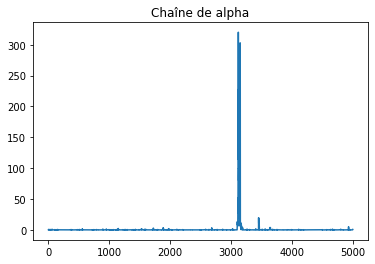

In [64]:
plt.plot(X[4])
plt.title("Chaîne de alpha");